In [1]:
import torch
print("Device:", "cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))



Device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
!pip install ipywidgets --upgrade



In [3]:
!pip install ipywidgets jupyterlab_widgets --upgrade


In [4]:
from tqdm.notebook import tqdm


In [5]:
!pip install matplotlib


In [34]:
!pip install torch torchvision torchaudio matplotlib tqdm pytorch-msssim --quiet

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import random, os
from pytorch_msssim import ssim


In [35]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Using device: {DEVICE} | GPU: {torch.cuda.get_device_name(0) if DEVICE=='cuda' else 'None'}")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


🚀 Using device: cuda | GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [36]:
def load_datasets(batch_size=128):
    # --- MNIST ---
    transform_mnist = transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(2, fill=0)      # 28×28 → 32×32 to match CIFAR
    ])
    mnist = datasets.MNIST(root="data", train=True, download=True, transform=transform_mnist)
    mnist_loader = DataLoader(mnist, batch_size=batch_size, shuffle=True)

    # --- CIFAR-10 ---
    transform_cifar = transforms.Compose([
        transforms.ToTensor()
    ])
    cifar = datasets.CIFAR10(root="data", train=True, download=True, transform=transform_cifar)
    cifar_loader = DataLoader(cifar, batch_size=batch_size, shuffle=True)

    return mnist_loader, cifar_loader

mnist_loader, cifar_loader = load_datasets()
print("✅ Loaded MNIST (1×32×32) and CIFAR-10 (3×32×32)")


Files already downloaded and verified
✅ Loaded MNIST (1×32×32) and CIFAR-10 (3×32×32)


In [37]:
class UNetDenoiser(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Decoder + skip connections
        self.up1 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.dec1 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.up2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.final = nn.Sequential(
            nn.Conv2d(64, in_channels, 3, padding=1),
            nn.Sigmoid()                 # output in [0, 1]
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        d1 = self.up1(e3)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)
        d2 = self.up2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)
        return self.final(d2)


In [38]:
def hybrid_loss(recon, target, alpha=0.85):
    mse_loss = F.mse_loss(recon, target)
    ssim_loss = 1 - ssim(recon, target, data_range=1.0, size_average=True)
    return alpha * ssim_loss + (1 - alpha) * mse_loss


In [39]:
def train_unet_denoiser(model, dataloader, epochs=15, noise_std=0.1, mask_prob=0.3):
    optimizer = optim.Adam(model.parameters(), lr=2e-4)
    model.train()

    for epoch in range(1, epochs + 1):
        total = 0
        for imgs, _ in tqdm(dataloader, desc=f"Epoch {epoch}/{epochs}"):
            imgs = imgs.to(DEVICE)
            # Random mask (encryption simulation)
            mask = (torch.rand_like(imgs) > mask_prob).float()
            masked = imgs * mask
            # Gaussian noise
            noisy = masked + noise_std * torch.randn_like(masked)
            noisy = torch.clamp(noisy, 0., 1.)
            # Forward
            optimizer.zero_grad()
            recon = model(noisy)
            loss = hybrid_loss(recon, imgs)
            loss.backward()
            optimizer.step()
            total += loss.item()
        print(f"Epoch {epoch} | Avg Loss: {total/len(dataloader):.6f}")
    print("✅ Training Complete.")


In [40]:
def show_images(orig, masked, recon, n=6, title="Results"):
    orig, masked, recon = orig[:n].cpu(), masked[:n].cpu(), recon[:n].cpu()
    gray = orig.shape[1] == 1
    plt.figure(figsize=(12, 6))
    for i in range(n):
        # Original
        plt.subplot(3, n, i+1)
        img = orig[i].permute(1, 2, 0).squeeze()
        plt.imshow(img, cmap='gray' if gray else None)
        plt.axis("off"); plt.title("Original")
        # Masked + Noise
        plt.subplot(3, n, i+1+n)
        img = masked[i].permute(1, 2, 0).squeeze()
        plt.imshow(img, cmap='gray' if gray else None)
        plt.axis("off"); plt.title("Masked + Noisy")
        # Reconstruction
        plt.subplot(3, n, i+1+2*n)
        img = recon[i].permute(1, 2, 0).squeeze()
        plt.imshow(img, cmap='gray' if gray else None)
        plt.axis("off"); plt.title("Reconstructed")
    plt.suptitle(title, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()


🧠 Training U-Net on MNIST…


Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1 | Avg Loss: 0.129813


Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2 | Avg Loss: 0.075508


Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3 | Avg Loss: 0.072249


Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4 | Avg Loss: 0.070319


Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5 | Avg Loss: 0.069163
✅ Training Complete.


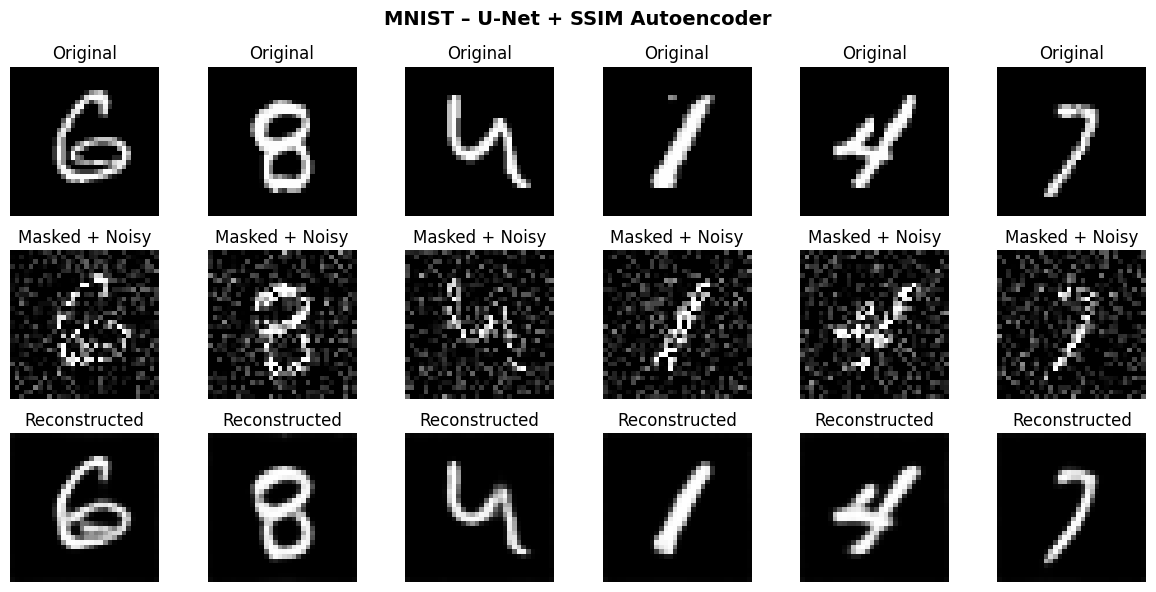

In [41]:
print("🧠 Training U-Net on MNIST…")
unet_mnist = UNetDenoiser(in_channels=1).to(DEVICE)
train_unet_denoiser(unet_mnist, mnist_loader, epochs=5, noise_std=0.2, mask_prob=0.4)

imgs, _ = next(iter(mnist_loader))
imgs = imgs.to(DEVICE)
mask = (torch.rand_like(imgs) > 0.4).float()
masked = imgs * mask + 0.2 * torch.randn_like(imgs)
masked = torch.clamp(masked, 0., 1.)
with torch.no_grad():
    recon = unet_mnist(masked)
show_images(imgs, masked, recon, title="MNIST – U-Net + SSIM Autoencoder")


In [42]:
!pip install tqdm
!pip install sqlalchemy


🧠 Training U-Net on CIFAR-10… (this may take a few minutes on GPU)


Epoch 1/15:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1 | Avg Loss: 0.178111


Epoch 2/15:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2 | Avg Loss: 0.128940


Epoch 3/15:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3 | Avg Loss: 0.118984


Epoch 4/15:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4 | Avg Loss: 0.114163


Epoch 5/15:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5 | Avg Loss: 0.111293


Epoch 6/15:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6 | Avg Loss: 0.109551


Epoch 7/15:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7 | Avg Loss: 0.107992


Epoch 8/15:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8 | Avg Loss: 0.106824


Epoch 9/15:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9 | Avg Loss: 0.105809


Epoch 10/15:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.105241


Epoch 11/15:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.104284


Epoch 12/15:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.103904


Epoch 13/15:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.103371


Epoch 14/15:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.102974


Epoch 15/15:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.102705
✅ Training Complete.


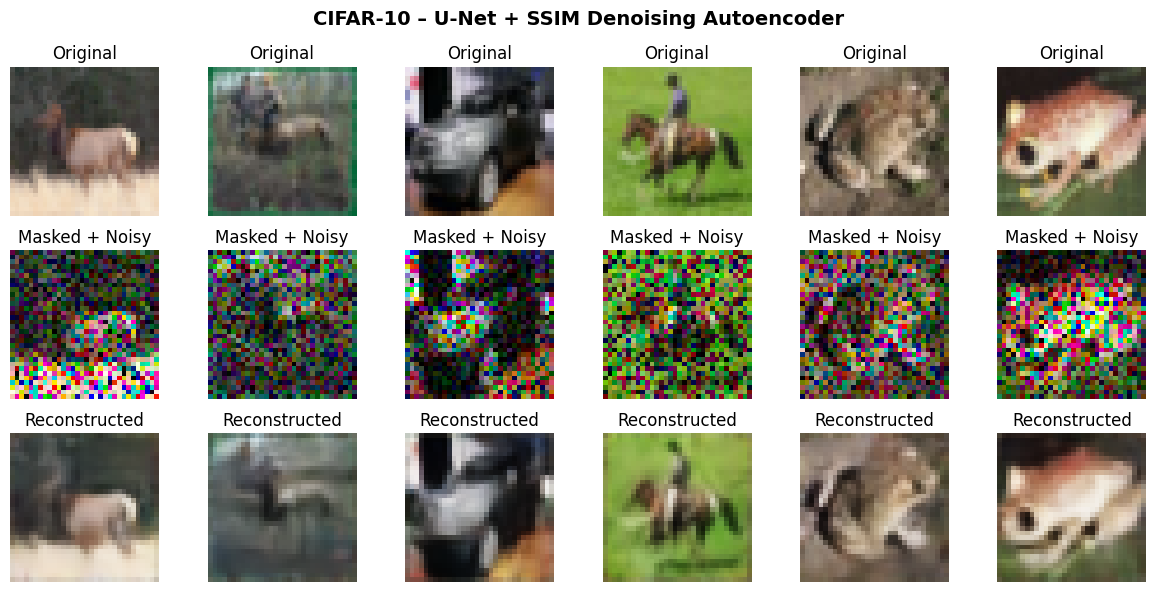

In [43]:
print("🧠 Training U-Net on CIFAR-10… (this may take a few minutes on GPU)")
unet_cifar = UNetDenoiser(in_channels=3).to(DEVICE)
train_unet_denoiser(unet_cifar, cifar_loader, epochs=15, noise_std=0.1, mask_prob=0.3)

imgs, _ = next(iter(cifar_loader))
imgs = imgs.to(DEVICE)
mask = (torch.rand_like(imgs) > 0.3).float()
masked = imgs * mask + 0.1 * torch.randn_like(imgs)
masked = torch.clamp(masked, 0., 1.)
with torch.no_grad():
    recon = unet_cifar(masked)
show_images(imgs, masked, recon, title="CIFAR-10 – U-Net + SSIM Denoising Autoencoder")
